In [2]:
# using Pkg;Pkg.status()
# """
# Photodynamics.jl is built on NbodyGradient.jl and Limbdark.jl
# # Distance: AU
# # Time: Days
# # Masses: Solar Masses
# # Angles: radians
# """
# using PyPlot,PyCall,DelimitedFiles
# using Statistics,LsqFit,Optim,Photodynamics

How to add moons to existing Nbody Gradient code?
- give keplerian elements in https://github.com/ericagol/NbodyGradient.jl/blob/master/src/ics/InitialConditions.jl
- which would come first? moon around earth or [EMB around sun]
    - t0 would be when moon transits earth

In [4]:
using Photodynamics
""" Hierarchy
- Full Hierarchy Matrix: `H::Matrix{<:Real}`: Provide the hierarchy matrix, directly.

`H = [-1 1 0 0; 0 0 -1 1; -1 -1 1 1; -1 -1 -1 -1]`. Produces the same system as `H = [4,2,1]`.

[SV --,
-- EM,
SVB EMB
-1 -1 -1 -1]
"""
# need to add a method that applies moon elements, HOW?

# function ElementsIC(t0::T, H::Matrix{<:Real}, elems::Elements{T}...) where T<:AbstractFloat
#     elements = zeros(T,size(H)[1],7)
#     fields = [:m, :P, :t0, :ecosω, :esinω, :I, :Ω]
#     for i in eachindex(elems)
#         elements[i,:] .= [getfield(elems[i],f) for f in fields]
#     end
#     return ElementsIC(t0,T.(H),elements)
# end

star=Elements(m=1.0, P=0.0  ,    
    t0=0.0   ,
    ecosω=0.0  ,  
    esinω=0.0  , 
    I=0.0   ,
    Ω=0.0)
p1=Elements(m=2.5422162292092204e-6,
   P=224.70078014619864,
  t0=3503.765349062694,
    ecosω=-0.003,
    esinω=-0.006,
    I=pi/2,
    Ω=0.0)
p2=Elements(m=3.0256056455411807e-6,
   P=365.2564540136157,
  t0=3624.4021734758985,
     ecosω=0.011,
     esinω=0.012,
        I=pi/2,
        Ω=0.0)
moon=Elements(m=0.012*(p2.m),P=27.3,t0=3624.3949611424468,ecosω=p2.ecosω,esinω=p2.ecosω)
H=[-1 1 0 0;0 0 -1 1; -1 -1 1 1; -1 -1 -1 -1]

t0=3283.5;tmax=4000.0;
ic=ElementsIC(t0,H,[star;p1;p2;moon])
rstar = 0.00465047 # Sol (Rstar/AU)
u_n = [0.39256, 0.29064];  # Quad. Limbdarkening coefficients
k_moon = [0.0087002, 0.0091705, 0.27*0.0091705]  # Radius ratios with moon

cadence = 2 / 60 / 24  # 2 minute cadence in days
obs_duration = tmax-t0  # Duration of observations in days
tobs = collect(t0:cadence:t0+obs_duration) 
# allocate arrays and initialzie state
lc = Lightcurve(cadence, tobs, ones(length(tobs)), zeros(length(tobs)), u_n, k_moon, rstar); intr = Integrator(0.05, obs_duration) ;
s=State(ic)
ts = TransitSeries(obs_duration,ic) ;# args: max time obs, IC, h [step size for series pnts]
tt = TransitTiming(obs_duration,ic) ;#TransitTiming(intr.tmax,ic) # ;need this for grad;

In [ ]:
intr(s, ts, tt; grad=false);
compute_lightcurve!(lc, ts);

In [ ]:
struct PhotometryModel{T<:Real}
    ic::ElementsIC{T}
    tt::TransitTiming{T}
    ts::TransitSeries{T,Photodynamics.ComputedTimes}
    d::NbodyGradient.Derivatives{T}
    lc::Lightcurve{T}
#     intr::Integrator{T}
#     J::Matrix{T}
end

In [2]:
# to load data
# data_SPEC = readdlm("../data/EMBtransit_times30.txt",comments=true,comment_char='#');
# p=sortperm(data_SPEC[:,3])
# nobs=length(p)
# tt_data=zeros(nobs,4)
# tref=2430000;
# tt_data[:,4] .= data_SPEC[:,4][p] ; tt_data[:,3] .= data_SPEC[:,3][p]#.-tref
# tt_data[:,2] .= data_SPEC[:,2][p]; tt_data[:,1] .= data_SPEC[:,1][p];

In [3]:
# """ to simulate transit times
# # data=[body,tt0,ttimes,sigtt]
# PLANET_INDX=data[1];TRANSIT_INDX=data[2];
# TT_OBS=data[3];SIG_TT=data[4];TCALC_LIN=data[5];

# """
include("../ttv_ss/sim_times.jl") # has regress.jl
jd1=2.4332825e6 ; sigma=30 ; nyear=20
tref=2430000;  # value subtracted from times when fitting
obs="fromEV"
@time data=sim_obs_and_find_times(jd1,sigma,nyear,obs);
p=sortperm(data[3])
tt0=data[5][p] .-tref; nobs=length(tt0)
tt_data=zeros(nobs,4)
tt_data[:,4] .= data[4][p] ; tt_data[:,3] .= data[3][p].-tref
tt_data[:,2] .= data[2][p]; tt_data[:,1] .= data[1][p];
tt_data

P1 linear coefficients: -16496.23050834611 , 224.70077694799764
P2 linear coefficients: -16375.590354466345 , 365.25636126999626
Peak amplitude
A_TTV1= 4.136417582631111
A_TTV2= 6.677052900195122
  0.758173 seconds (835.43 k allocations: 48.277 MiB, 2.37% gc time, 98.66% compilation time)


52×4 Matrix{Float64}:
 1.0   0.0   3503.77  0.000347222
 2.0   0.0   3624.41  0.000347222
 1.0   1.0   3728.47  0.000347222
 1.0   2.0   3953.17  0.000347222
 2.0   1.0   3989.66  0.000347222
 1.0   3.0   4177.87  0.000347222
 2.0   2.0   4354.92  0.000347222
 1.0   4.0   4402.57  0.000347222
 1.0   5.0   4627.28  0.000347222
 2.0   3.0   4720.18  0.000347222
 1.0   6.0   4851.98  0.000347222
 1.0   7.0   5076.68  0.000347222
 2.0   4.0   5085.44  0.000347222
 ⋮                    
 2.0  15.0   9103.26  0.000347222
 1.0  25.0   9121.29  0.000347222
 1.0  26.0   9345.99  0.000347222
 2.0  16.0   9468.51  0.000347222
 1.0  27.0   9570.69  0.000347222
 1.0  28.0   9795.39  0.000347222
 2.0  17.0   9833.77  0.000347222
 1.0  29.0  10020.1   0.000347222
 2.0  18.0  10199.0   0.000347222
 1.0  30.0  10244.8   0.000347222
 1.0  31.0  10469.5   0.000347222
 2.0  19.0  10564.3   0.000347222

### SS parameters
#### From PlanetaryBodyData.pdf
- true $\lambda$ : [181.97973, 100.46435] degrees jup=34.40438 |
- true $\varpi$ : [131.53298, 102.94719] |
- inclination: [3.39471, 0.00005] degrees |
- eccentricity: [0.00677323, 0.01671022] 

#### Solar properties
- surface gravity -> $g= 274$ m/s2 ; https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html 
- FEH -> $\log{\epsilon}_{Fe} = 7.46 \pm 0.04$ 
- limb dark coefficients -> $u1=0.39256$, $u2=0.29064$ https://arxiv.org/pdf/1403.3487.pdf 

In [46]:
struct PhotometryModel{T<:Real}
    ic::ElementsIC{T}
    tt::TransitTiming{T}
    ts::TransitSeries{T,Photodynamics.ComputedTimes}
    d::NbodyGradient.Derivatives{T}
    lc::Lightcurve{T}
#     intr::Integrator{T}
#     J::Matrix{T}
end

2-element Vector{Float64}:
 0.0087002
 0.0091705

In [40]:
θ=[2.5422162292092204e-6
  224.70078014619864
 3503.765349062694
  -0.003 
    -0.006 
    3.0256056455411807e-6
  365.2564540136157
 3624.4021734758985
    0.011 
    0.012 
# 0.3227e-6
#   686.980     
#   383.823    
#     0.0403  
#    0.0268 
# 0.0007712378609020167
#  4210.1287973187655
#   603.9841005839645
#    0.0131   
#    0.0925
# 2.8420e-4
# 	10755.5
# 	892.111
# 	-0.051
# 	0.014
    0.0087002
    0.0091705
    0.39256
    0.29064
    0.00465047] # Real SS data

15-element Vector{Float64}:
    2.5422162292092204e-6
  224.70078014619864
 3503.765349062694
   -0.003
   -0.006
    3.0256056455411807e-6
  365.2564540136157
 3624.4021734758985
    0.011
    0.012
    0.0087002
    0.0091705
    0.39256
    0.29064
    0.00465047

In [26]:

t0=3282.5 #starting point of integration 
tmax = 7000.0  # Time to integrate to. when nyear = 30
# h= 0.5 # timestep
# function nbody_model(t0,tmax,nplanet,pbest_logP) need to initialize model:
function nbody_wrapper(param::Vector{T};init_model::Bool=false,jacobian::Bool=false,compute_lc::Bool=false) where T<:Real
#     @assert(length(param)==5*nplanet)
    # Stellar/transit properties
    rstar = 0.00465047 # Sol (Rstar/AU)
    k = [0.0087002, 0.0091705]  # Radius ratios
    u_n = [0.39256, 0.29064];  # Quad. Limbdarkening coefficients
    # set up initial conditions: 
    star = Elements(m = 1.0)
    N=nplanet+1
    elements=zeros(N,7);pl_param=zeros(length(param))
    elements[1,1]=1.0
    if jacobian
        pl_param=vec(transpose(reshape(param,nplanet,5)))
    else
        pl_param=copy(param)
    end
    for i=1:nplanet
        elements[i+1,1:5] .= pl_param[(i-1)*5 + 1:5*i]
        elements[i+1,6] = pi/2;    
        elements[i+1,7] = pi   
    end
    cadence = 2 / 60 / 24  # 2 minute cadence in days
    obs_duration = tmax-t0  # Duration of observations in days
    tobs = collect(t0:cadence:t0+obs_duration) 
    ic = ElementsIC(t0, N, elements) 
    lc = Lightcurve(cadence, tobs, ones(length(tobs)), zeros(length(tobs)), u_n, k, rstar)
    intr = Integrator(0.05, obs_duration) # OR  intr=Integrator(h,t0,tmax)
    s = State(ic) # keeps track of the current state of the system
    # Compute the dynamical model
    ts = TransitSeries(obs_duration,ic) # args: max time obs, IC, h [step size for series pnts]
    tt = TransitTiming(obs_duration,ic) #TransitTiming(intr.tmax,ic) # ;need this for grad; 
    intr(s, ts, tt; grad=false)
    d = NbodyGradient.Derivatives(Float64, ic.nbody)
    compute_lightcurve!(lc, ts)
    model=PhotometryModel(ic,tt,ts,d,lc)
    if init_model
        return model
    elseif compute_lc
#         println("Returns lightcurve (LC) and transit series (TC).")
     # Compute the photometry: (only works if given radius ratios for all planets) 
        return lc
    else
    tts=[tt.tt[i,:][tt.tt[i,:] .!= 0.0] for i=2:N]
    return tts
    end
end

nbody_wrapper (generic function with 1 method)

In [27]:
# ttmodel,ic=nbody_wrapper(5,SS_params;init_model=true)
# ttmodel.tt
model=nbody_wrapper(2,SS_params[1:10];init_model=true)

PhotometryModel{Float64}(ElementsIC{Float64}([1.0 0.0 … 0.0 0.0; 2.5422162292092204e-6 224.70078014619864 … 1.5707963267948966 3.141592653589793; 3.0256056455411807e-6 365.2564540136157 … 1.5707963267948966 3.141592653589793], [-1.0 1.0 0.0; -1.0 -1.0 1.0; -1.0 -1.0 -1.0], [-1.0 1.0 0.0; -0.9999974577902335 -2.5422097663622943e-6 1.0; -0.9999944322091255 -2.5422020746808985e-6 -3.025588799601678e-6], 3, [1.0, 2.5422162292092204e-6, 3.0256056455411807e-6], 3282.5, true), TransitTiming{Float64}([0.0 0.0 … 0.0 0.0; 3503.7612231832118 3728.458604855531 … 0.0 0.0; 3624.4083190294946 3989.669067845751 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0

In [31]:
setup_ics!(SS_params[1:10],model.ic)

In [7]:
function chi_square(ttobs,model)
    ntransit=size(ttobs)[1]
    chisq=0.0
    for i=1:ntransit
        chisq+= (ttobs[i,3] .- model[i])./ttobs[i,4]^2
    end
    return chisq
end

# sort the data by the time & match obs transits to model transits
function match_transits(ttobs,elements,tt,count)
    ntransit=size(ttobs)[1]
	ip = zeros(Int64,ntransit); #     ip=Array{Int64}(undef, ntransit) # planet index
    jp = zeros(Int64,ntransit); #     jp=Array{Int64}(undef, ntransit) # transit index
	i = 1; ip0 = 0;
	tmod = zeros(Float64,ntransit); j = 1;
	while i <= ntransit
		  ip[i] = ttobs[i]+1 # add 1 bcuz first object is star in Nbodygradient
		  if ip[i] != ip0 # and it shouldn't
		    j=1
		    ip0 = ip[i]
		  end
		  tdiff = Inf
# When transit number < total transits observed & diff. is > 0.1 Period of planet i 
# Q. why? really large TTV signal always gonna be smaller than 1/10th of period
# if transits are in order, only need to compare to last observed transit
# maybe should be abs val of diff btween current observed time and all of the times 
#   BUT this assuems good initial guess close to correct value or good model fit
		  while j <= count[ip[i]] && tdiff > 0.1*elements[ip[i],2]
            # Find difference between model time and observed time for i planet:
			tdiff = abs(tt[ip[i],j] - ttobs[i,3])
		    j += 1
		  end
		  jp[i] = j-1
#         @show tdiff
        if tdiff> 0.1*elements[ip[i],2]
            tmod[i]=-1
        else
#         @show ip[i],j,tt[ip[i],j]
		  tmod[i] = tt[ip[i],jp[i]]
        end
		  i += 1
        ip0=0
	end
	return tmod,ip,jp
end
# tmod,ip,jp=match_transits(tt_data,ic.elements,ttmodel.tt,ttmodel.count)

match_transits (generic function with 1 method)

In [8]:
tmod,ip,jp=match_transits(tt_data,ic.elements,ttmodel.tt,ttmodel.count)
tmod

52-element Vector{Float64}:
  3503.7622130382947
  3624.4102883727824
  3728.4604414423648
  3953.159634652816
  3989.6716053687164
  4177.85692532632
  4354.931742715217
  4402.554838938232
  4627.258892054654
  4720.186921975859
  4851.957448410524
  5076.653733660535
  5085.450297729484
     ⋮
  9103.317144860124
  9121.235484223831
  9345.932644185848
  9468.580568239944
  9570.630811871733
  9795.330408073669
  9833.842185810532
 10020.027838508704
 10199.102299966926
 10244.72579591833
 10469.42955413623
 10564.359234845799

In [50]:
function optimize_nbody(tt_data,init_params,nplanet)
# anonymous function that optimizes initial conditions, given transit times from NbodyGrad?
ttmodel,ic=nbody_wrapper(nplanet,init_params;init_model=true);
tmod,ip,jp=match_transits(tt_data,ic.elements,ttmodel.tt,ttmodel.count)
N=ic.nbody 
# nplanet=N-1
intr=Integrator(h,t0,tmax) #t0 and tmax defined above. do i need to redefine intr?
# Initialize data structures:
# tt = TransitTiming(intr.tmax,ic);
s=State(ic)
d=NbodyGradient.Derivatives(eltype(s.x),s.n)
# Save initial elements:
elements0=ic.elements
# Derivatives in jacobian matrix work best when the values are comparable.
# Rescale factors to make derivatives similar orders of magnitude:
mfac = 1e6; eccfac=1e3
pfac = ones(nplanet,5); 
pfac[:,1] .= mfac; pfac[:,4:5] .= eccfac
params0=vec(ic.elements[2:N,1:5].*pfac) # of order unity
# @show params0
# check that eccentricity is inbounds [0, 1), masses are positive,
function in_bounds(param)
    p=param./vec(pfac)
    if minimum(p[1:nplanet]) <= 0.0 || minimum(p[nplanet+1:nplanet+2]) <= 0.0 ||
    maximum(abs.(p[3*nplanet+1:5*nplanet])) >= .9 # arbitrary limit
        return false
    end
    return true
end
    # compute model times (with grad false, with initial conds) returns ordered times:
function compute_model(tephem,param) # compute transit times model w/ no gradients
    elements_new = copy(elements0)
    elements_new[2:N,1:5].=reshape(param[1:5*nplanet]./vec(pfac),nplanet,5)
    ic=ElementsIC(t0,N,elements_new)
    s=State(ic)
    tt = TransitTiming(intr.tmax,ic);
    intr(s,tt,grad=false)
    tmod_new=Array{Float64}(undef, nobs)
    i=1
    while i<=nobs
        tmod_new[i]=tt.tt[ip[i],jp[i]] # requires 
        i+=1
    end
    return tmod_new
end
    # compute jacobian of TT wrt (5*nplanet) model params
function compute_jacobian(tephem,param) 
        #needs nobs,model
        model.ic.elements
    # put parameters back into elements matrix:
    elements_new = copy(elements0)
    elements_new[2:N,1:5].=reshape(param[1:5*nplanet]./vec(pfac),nplanet,5)
    ic=ElementsIC(t0,N,elements_new)
    # initialize the state and the TT structure:
    s=State(ic) 
    tt = TransitTiming(intr.tmax,ic);
    intr(s,tt,d,grad=true) # Run integrator w/ derivative structure
    J = zeros(nobs,5*nplanet)
    # Place timing derivatives into Jacobian matrix. 
        #Q?Derivative matrix has mass last:
    for itrans=1:nobs
        iparam=1  # This is the index in param0/p of all parameters
    # Jacobian wrt mass-ratio:
        for iplanet=1:nplanet
            J[itrans,iparam] = tt.dtdelements[ip[itrans],jp[itrans],7,iplanet+1]/mfac
            iparam += 1
        end
    # Jacobian wrt period, t0, e*cos(omega), e*sin(omega):
        for k=1:4
          for iplanet=1:nplanet
#             iparam = k*nplanet+iplanet  # This is the index in param0 of all parameters
            J[itrans,iparam] = tt.dtdelements[ip[itrans],jp[itrans],k,iplanet+1]/pfac[iplanet,k+1]
            iparam += 1 # Move to next varied parameter
          end
        end
    end
    return J
end
if !in_bounds(params0)
    println("Not in bounds.") 
end
chisq0=chi_square(tt_data,tmod)
println("Initial chisq=",chisq0)
tol=1e-5;niter=0; itmax=20
tt0=tt_data[:,2]
chi=0.0
@show 
weight = ones(nobs) ./ tt_data[:,4].^2 ;
# while niter <= 5# && chi>=chisq0
    res = curve_fit((tt0,pbest) -> compute_model(tt0,pbest),compute_jacobian,tt0,tt_data[:,3],weight,params0)
    new_params=res.param./vec(pfac)
    @show new_params
    new_tts=nbody_wrapper(nplanet,new_params,jacobian=true)
    tmods=reduce(append!, new_tts, init=Float64[])
    chi=chi_square(tt_data,tmods)
    println("New chi=",chi)
    niter+=1
# end
    return res,chi
end

optimize_nbody (generic function with 2 methods)

In [51]:
nplanet=2
init_params=[3e-6,
  224.700,
 3503.761869180093,
   0.01,
    0.01,
    3e-6,
  365.2564,
 3624.4081674077343,
   0.01,
    0.01]
@time test,chi=optimize_nbody(tt_data,init_params,nplanet)

params0 = [3.0, 3.0, 224.7, 365.2564, 3503.761869180093, 3624.4081674077343, 10.0, 10.0, 10.0, 10.0]
Initial chisq=1.3482473888430325e7
new_params = [3.04291715097327e-6, 2.0787089760761445e-6, 224.70150476276646, 365.2578676474278, 3503.7696582754484, 3624.410804892697, -0.06940928505120048, -0.053258877719410354, 0.1787562261693674, 0.13150009445627897]
New chi=-3.896062188853538e11
new_params = [3.04291715097327e-6, 2.0787089760761445e-6, 224.70150476276646, 365.2578676474278, 3503.7696582754484, 3624.410804892697, -0.06940928505120048, -0.053258877719410354, 0.1787562261693674, 0.13150009445627897]
New chi=-3.896062188853538e11
new_params = [3.04291715097327e-6, 2.0787089760761445e-6, 224.70150476276646, 365.2578676474278, 3503.7696582754484, 3624.410804892697, -0.06940928505120048, -0.053258877719410354, 0.1787562261693674, 0.13150009445627897]
New chi=-3.896062188853538e11


LoadError: InterruptException:

In [22]:
    test.param

10-element Vector{Float64}:
    3.04291715097327
    2.0787089760761446
  224.70150476276646
  365.2578676474278
 3503.7696582754484
 3624.410804892697
  -69.40928505120047
  -53.25887771941036
  178.7562261693674
  131.50009445627896

In [44]:
test2,chi2=optimize_nbody(tt_data,p3_param,3)

ic.elements[2:N, 1:5] .* pfac = [2.5422162292092203 224.70078014619864 3503.765349062694 -2.634290692237901 7.069884666418407; 3.0256056455411806 365.2564540136157 3624.4021734758985 12.05927363902475 8.297107290864002; 771.2378609020167 4210.1287973187655 603.9841005839645 16.165451882874706 -42.491363498421855]
Initial chisq=9.68504054609444e6
new_params = [3.6185640052991167e-6, 2.5166827505111597e-6, 5.740117235355872e-5, 224.7017187010129, 365.25583706377137, 4034.519314338262, 3503.7695024136333, 3624.409858674854, 785.8077923692747, -0.056563071777838474, -0.043205875492452375, -0.10663124685468599, 0.06711415011694322, 0.040985007428289054, 0.5717180999555397]
New chi=-3.8960609127763135e11


(LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([3.618564005299117, 2.5166827505111597, 57.40117235355872, 224.7017187010129, 365.25583706377137, 4034.519314338262, 3503.7695024136333, 3624.409858674854, 785.8077923692747, -56.56307177783847, -43.20587549245238, -106.63124685468598, 67.11415011694322, 40.98500742828905, 571.7180999555396], [0.3806373497354798, 1.9407205771130975, 0.7587248302297667, 0.4537244205130264, 1.8292542621202301, 1.0398411666392349, -1.4033313427353278, -1.89893058326561, -1.215242292091716, -0.04250758560374379  …  1.1598144244635478, 0.14792952686548233, -0.18001134507358074, -1.6203898983076215, -1.9477989489678293, -1.3522569020278752, -0.09239971695933491, 2.921336775762029, -0.014430148294195533, 0.013684902805835009], [-0.0006104737305770997 -1.8694492202727493 … -0.14821547497941237 0.01860958711970469; 1.810696107478649 0.0022984244371225863 … 0.43539244525291 

In [28]:
# best.param./vec(pfac

10-element Vector{Float64}:
    2.614148198323461e-6
    3.1311506469759116e-6
  224.7035596050799
  365.2534796866889
 3503.7670082863037
 3624.399731143171
    0.010567478645214083
    0.009219826271962172
   -0.04858687891641594
   -0.05107455631479781

In [65]:
new_params=best.param./vec(pfac)
new_tts=nbody_wrapper(nplanet,new_params,jacobian=true)
new_model=[new_tts[1];new_tts[2]]
chi=chi_square(tt_data,new_model)

4.4760310733301796e7

In [109]:
# tmod_new=compute_model(tt_data[:,3],params0);
# J=compute_jacobian(tt_data[:,3],params0);
telapse = 0.0;     tstart = time()
weight = ones(nobs) ./ tt_data[:,4].^2 
#     new_param=params0.+100.0 ; 
tol=1e-5;niter=0; itmax=20
chi=0.0
while niter < itmax
res = curve_fit((tt0,pbest) -> compute_model(tt0,pbest),compute_jacobian,tt0,tt_data[:,3],weight,params0)
#         chi=chi_square(tt_data,(compute_model(tt0,params1./vec(pfac))))
#         println("New chi=",chi)
# niter+=1
end
telapse = time()-tstart
# #     @time fit=curve_fit(compute_model, compute_jacobian,tt0,tt_data[:,3],weight,params0)
#     return pbest
# end

45.00387001037598

In [30]:
# tmod_new=compute_model(tt0,
nt1=48;nt2=30
p1_data=[data[i][1:nt1] for i=1:5]
p2_data=[data[i][nt1+1:nt1+nt2] for i=1:5]
tts=nbody_wrapper(2,best.param./vec(pfac),jacobian=true);
# ttv_analytic=TTVFaster.ttv_wrapper(tt0,2,[nt1,nt2],param,5)
# ttmodel=[tts[1];tts[2]]
# time1=collect( res.param[5]./pfac[5] .+ range(0.0,stop=nt1+1,length=nt1).*res.param[3]./pfac[3]);
# time2=collect( res.param[6]./pfac[6] .+ range(0.0,stop=nt2+1,length=nt2).*res.param[4]./pfac[4]);
# fitmc=jldopen("../ttv_ss/FITS/fromEMB/p2_fit30s30yrs.jld2","r")

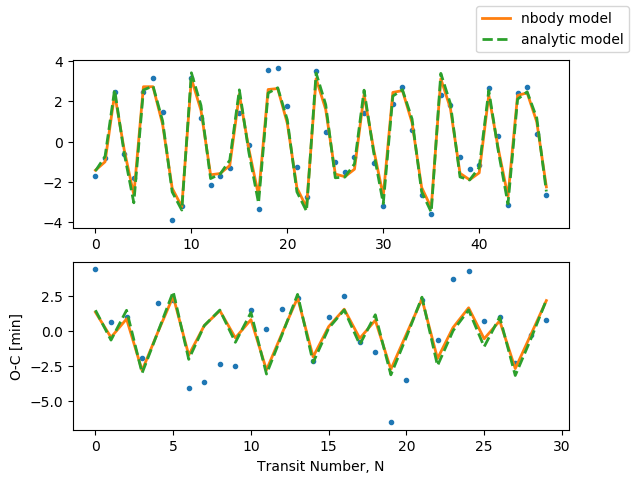

PyObject Text(0.5, 24.0, 'Transit Number, N')

In [231]:
fig=figure()
ax2=subplot(211)
ax2.plot((p1_data[3].-p1_data[5]).*24*60,".")
ax2.plot((tts[1].-(p1_data[5].-tref)).*24*60)
ax2.plot((ttv_analytic[1:nt1].-(p1_data[5].-tref)).*24*60,linestyle="--")

ax1=subplot(212)
ax1.plot((p2_data[3].-p2_data[5]).*24*60,".")
ax1.plot((tts[2].-(p2_data[5].-tref)).*24*60,label="nbody model")
ax1.plot((ttv_analytic[nt1+1:nt1+nt2].-(p2_data[5].-tref)).*24*60,label="analytic model",linestyle="--")
fig.legend()
ax1.set_ylabel("O-C [min]")
ax1.set_xlabel("Transit Number, N")

Since TTVFaster and NbodyGradient use different definitions of period, the linear ephemerides won't agree. I use the ephem found from JPLEphemerides in creating the TTV plots. This differes from the current method, in which I calculate new linear times based on the best-fit TTVFaster parameters for period and t0.

In [251]:
init_params=[2.65e-6,
  224.700,
 3503.761869180093,
   -0.01,
    0.01,
    3.03e-6,
  365.25,
 3624.4081674077343,
   -0.01,
    0.01]
# fit = curve_fit(model, xdata=tt0, ydata=tt, p0=init_params)# input = tt0, output=params
# fit = curve_fit((input,output) -> model_to_fit, xdata=tt0, ydata=tt, p0=init_params)
weight = ones(78)./ sigtt.^2 
fit=curve_fit((tt0,pbest) -> nbody_wrapper(tt0,pbest),(tt0.-tref)[p],tmod,weight,init_params)

LoadError: MethodError: no method matching -(::Tuple{TransitTiming{Float64}, ElementsIC{Float64}}, ::Vector{Float64})
[0mClosest candidates are:
[0m  -([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at /Users/bethleelindor/.julia/packages/ChainRulesCore/7MWx2/src/tangent_types/thunks.jl:34
[0m  -([91m::StaticArraysCore.StaticArray[39m, ::AbstractArray) at /Users/bethleelindor/.julia/packages/StaticArrays/yXGNL/src/linalg.jl:18
[0m  -([91m::MvNormal[39m, ::AbstractVector{T} where T) at /Users/bethleelindor/.julia/packages/Distributions/GrN7f/src/multivariate/mvnormal.jl:296
[0m  ...

In [418]:
#   sigtt=[sigtt1;sigtt2] 
using TTVFaster

weight = ones(nt1+nt2)./ sigtt.^2 
tt=[tt1; tt2]
tt0=[t01; t02]
fit0 = curve_fit((tt0,params) -> TTVFaster.ttv_wrapper(tt0,nplanet,[48; 30],params,5,true),tt0,tt,weight,pbest_logP)
fit.resid

10-element Vector{Float64}:
  1.7501633451833777e-8
 -3.2844738484527625e-7
  1.823673301259987e-6
 -0.038619774525784245
  0.0003459732204765791
 -4.7803811464698526e-8
 -9.176164269319997e-6
  7.051033799143624e-5
 -0.02980058525944671
  0.0010147872237117796

In [8]:
# read in obs transit times and expected trans times
nt1,nt2=p2_fit["ntrans"]

tt1=p2_fit["tt"][1:nt1]                 #tobs
tt2=p2_fit["tt"][nt1+1:nt1+nt2]

sig_tt1=p2_fit["sigtt"][1:nt1]          #tobs_err
sig_tt2=p2_fit["sigtt"][nt1+1:nt1+nt2];

tt01=p2_fit["tt0"][1:nt1]               #tcalc_linear
tt02=p2_fit["tt0"][nt1+1:nt1+nt2]

mu1,P1,t01,ecos1,esin1=pbest_logP[1:5]
mu2,P2,t02,ecos2,esin2=pbest_logP[6:10] #tcalc_best
time1=collect(t01 .+range(0,stop=nt1-1,length=nt1) .* P1)  
time2=collect(t02 .+range(0,stop=nt2-1,length=nt2) .* P2);

linear fit biases slope and mean value. TTVFaster takes mean orbital elments (oscullating). Nbody gradient takes instantaneous. 

In [201]:
tt_nb1=tt.tt[2,:][tt.tt[2,:] .!= 0.0]
tt_nb2=tt.tt[3,:][tt.tt[3,:] .!= 0.0]
tt_nb=[tt_nb1 ; tt_nb2];

println("starting time for planet 1:",'\n',"from NBodyGrad: ",tt_nb1[1]," from TTVFaster: ",tt1[1])
println("starting time for planet 2:",'\n',"from NBodyGrad: ",tt_nb2[1]," from TTVFaster: ",tt2[1])
println("ending time for planet 1:",'\n',"from NBodyGrad: ",tt_nb1[end]," from TTVFaster: ",tt1[end])
println("ending time for planet 2:",'\n',"from NBodyGrad: ",tt_nb2[end]," from TTVFaster: ",tt2[end])
println(length(tt_nb)," ",length([tt1;tt2]))

starting time for planet 1:
from NBodyGrad: 3503.7615927486763 from TTVFaster: 3503.7653924068436
starting time for planet 2:
from NBodyGrad: 3624.4085177634483 from TTVFaster: 3624.4024799037725
ending time for planet 1:
from NBodyGrad: 14064.536181864245 from TTVFaster: 14064.702071556356
ending time for planet 2:
from NBodyGrad: 14216.960845412255 from TTVFaster: 14216.839391200338
78 78


- 12/18/23 : Somehow, routine with TTVFaster skips the transit for Venus (at t=14513.936223576813).
- 1/09/24 : Added break to while loop. Now stopping before t0[end]. pre-2024 runs dont have this constraint

In [ ]:
# CartesianIC(positions,velocities, masses, nbody)
# anonymous function that optimizes initial conditions, given transit times from NbodyGrad
# curve_fit((ic)-> TransitTiming(intr.tmax,ic),init_params)

In [2]:
# Setup simulated lightcurve
nplanet=2
Teff = 5768 # Kelvin
logg = 4.4 # surface gravity, cgs
rstar = 0.00465047 # Sol (Rstar/AU)
k = [0.0087002, 0.0091705]  # Radius ratios
u_n = [0.39256, 0.29064];  # Quad. Limbdarkening coefficients
star = Elements(m = 1.0)
p1=Elements(m=2.5422162292092204e-6,
            P=224.70078014619864,
            t0=3503.765349062694,
            ecosω=-0.003 ,
            esinω=-0.006 ,
            I = pi/2 )
p2=Elements(m=3.0256056455411807e-6,
            P=365.2564540136157,
            t0=3624.4021734758985,
            ecosω=0.011 ,
            esinω=0.012 ,
            I = pi/2 )
nyear=20
t0=0.0
cadence = 2 / 60 / 24  # 2 minute cadence in days
obs_duration = nyear*365.25  # Duration of observations in days
tobs = collect(t0:cadence:t0+obs_duration) 
ic = ElementsIC(t0,3,star,p1,p2)
lc = Lightcurve(cadence, tobs, ones(length(tobs)), zeros(length(tobs)), u_n, k, rstar)
# # Compute the dynamical model
intr = Integrator(0.05, obs_duration) # integrator
s = State(ic) # state of initial cond. 
ts = TransitSeries(obs_duration, ic) # args: max time obs, IC, h [step size for series pnts]
tt = TransitTiming(obs_duration, ic);
intr(s, ts, tt; grad=false)
# # Compute the photometry
compute_lightcurve!(lc, ts)

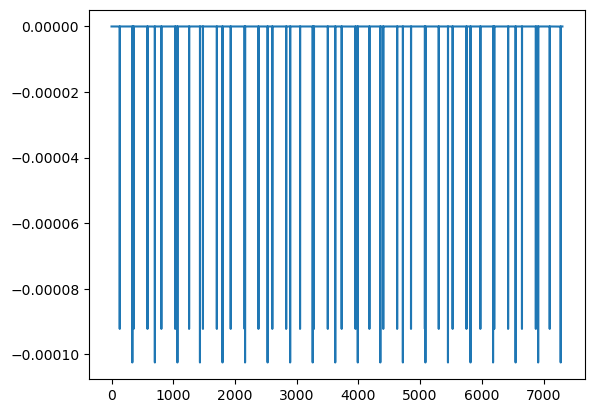

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd7df6e5160>

In [3]:
plot(lc.tobs,lc.flux)

In [4]:
using BoxLeastSquares
import BoxLeastSquares as BLS

In [7]:
typeof(lc.tobs)

Vector{Float64} (alias for Array{Float64, 1})

In [ ]:
result=BLS.BLS(vec(lc.tobs),vec(lc.flux).+1,duration=0.05)

In [9]:
BLS.BLS()

LoadError: MethodError: no method matching BLS()
[0mClosest candidates are:
[0m  BLS([91m::Any[39m, [91m::Any[39m) at /Users/bethleelindor/.julia/packages/BoxLeastSquares/Z8c46/src/bls.jl:143
[0m  BLS([91m::Any[39m, [91m::Any[39m, [91m::Any[39m; duration, periods, objective, oversample, kwargs...) at /Users/bethleelindor/.julia/packages/BoxLeastSquares/Z8c46/src/bls.jl:143

In [ ]:
# using Optim
# optimize(compute_photometry(θ,photodynamical_model),zeros(length(f)))
include("../toi-700/occultquad.jl")
u1=0.1;u2=0.1;p=0.05;z=0.0
init_params=[z,u1,u2,p]
model=occultquad(init_params)


In [76]:
# For fitting, define photodynamic model
# Derivatives in jacobian matrix work best when the values are comparable.
# Rescale factors to make derivatives similar orders of magnitude:
mfac = 1e6; eccfac=1e3
pfac = ones(nplanet,5); 
pfac[:,1] .= mfac; pfac[:,4:5] .= eccfac
params0=vec(ic.elements[2:N,1:5].*pfac) # of order unity
θ=[2.5422162292092204e-6
  224.70078014619864
 3503.765349062694
   -0.003
   -0.006
    3.0256056455411807e-6
  365.2564540136157
 3624.4021734758985
    0.011
    0.012
    0.0087002
    0.0091705
    0.39256
    0.29064
    0.00465047]
function setup_ics!(θ, ic; nparam=5)
    n = ic.nbody
    ic.elements[2:end, 1:nparam] .= reshape(θ, nparam, n-1)'
    ic.elements[1] = 1.0
    ic.m .= ic.elements[:,1]
    # creates A martrix presented in Hamers & Portegies Zwart 2016 (HPZ16)
    # located in src/ics/init_nbody.jl
    NbodyGradient.amatrix(ic) 
    return 
end
function compute_photometry(θ,model)
    nplanet = model.ic.nbody-1; nparam = 5
    setup_ics!(θ[1:nparam*nplanet], model.ic)
    k = sqrt.(θ[nparam*nplanet+1:end-3]) #radius ratios
    u_n = (θ[end-2:end-1]) # quadratic limb dark. coeefs
    rstar = θ[end] #
    s = State(model.ic)
    # zero out each array in derivatives. located in src/PreAllocArrays.jl
    NbodyGradient.zero_out!(model.tt)  #reset values to 0
    model.ts.count .= 0 
    model.lc.k .= k
    model.lc.u_n .= u_n
    model.lc.rstar .= rstar
    intr(s, model.ts, model.tt; grad=false)
    compute_lightcurve!(model.lc, model.ts)
    return model.lc.flux
end
function compute_jacobian(θ,model) 
    nplanet = model.ic.nbody-1; nparam = 5
    setup_ics!(θ[1:nparam*nplanet], model.ic)
    k = sqrt.(θ[nparam*nplanet+1:end-3]) #radius ratios
    u_n = (θ[end-2:end-1]) # quadratic limb dark. coedfs
    rstar = θ[end] 
    
    elements_new = copy(model.ic.elements)
    elements_new[2:N,1:5].=reshape(θ[1:5*nplanet]./vec(pfac),nplanet,5)
    ic=ElementsIC(t0,N,elements_new)
    
    # initialize the state and the TT structure:
    s = State(model.ic)
    NbodyGradient.zero_out!(model.tt)
    model.ts.count .= 0 
    model.lc.k .= k
    model.lc.u_n .= u_n
    model.lc.rstar .= rstar
    
    # Run integrator w/ derivative structure
    d=NbodyGradient.Derivatives(eltype(s.x),s.n)
    intr(s, model.ts,model.tt, d; grad=true)
    
   # Place timing derivatives into Jacobian matrix. 
    J = zeros(nobs,5*nplanet)
        #Q?Derivative matrix has mass last
    for itrans=1:nobs
        iparam=1  # This is the index in param0/p of all parameters
    # Jacobian wrt mass-ratio:
        for iplanet=1:nplanet
            J[itrans,iparam] = model.tt.dtdelements[ip[itrans],jp[itrans],7,iplanet+1]/mfac
            iparam += 1
        end
    # Jacobian wrt period, t0, e*cos(omega), e*sin(omega):
        for k=1:4
          for iplanet=1:nplanet
#             iparam = k*nplanet+iplanet  # This is the index in param0 of all parameters
            J[itrans,iparam] = model.tt.dtdelements[ip[itrans],jp[itrans],k,iplanet+1]/pfac[iplanet,k+1]
            iparam += 1 # Move to next varied parameter
          end
        end
    end
    return J
end
θ_init = [ic.elements[2:end,1:5]'[:]..., k..., u_n..., rstar]
ic_opt = deepcopy(ic)
tt_opt = TransitTiming(obs_duration+1.0, ic_opt)
ts_opt = TransitSeries(obs_duration+1.0, ic_opt)
lc_opt = Lightcurve(cadence, copy(tobs), similar(tobs), copy(tobs), copy(u_n), copy(k), rstar);
# d = NbodyGradient.Derivatives(Float64, ic.nbody);
photodynamical_model = PhotometryModel(ic_opt, tt_opt, ts_opt, d, lc_opt)
f=compute_photometry(θ,photodynamical_model)

5259601-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

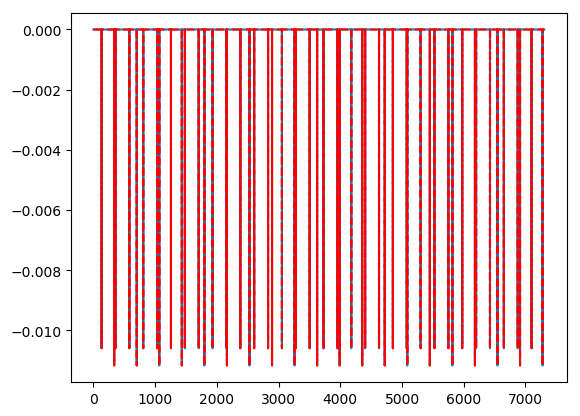

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa59a04b7b8>

In [71]:
plot(photodynamical_model.lc.tobs,photodynamical_model.lc.flux)
plot(photodynamical_model.lc.tobs,f,color="red",linestyle="--")

In [79]:
n=photodynamical_model.ic.nbody
reshape(θ[1:nparam*nplanet], nparam, n-1)'

2×5 adjoint(::Matrix{Float64}) with eltype Float64:
 2.54222e-6  224.701  3503.77  -0.003  -0.006
 3.02561e-6  365.256  3624.4    0.011   0.012

In [12]:
using HDF5
# h5write("/tmp/test2.h5", "test/lc", lc)
# lc.tobs,lc.flux
h5open("../ttv_ss/test/photodynamics_model.h5", "w") do file
    g = create_group(file, "lc") # create a group
    g["flux"] = lc.flux
    g["tobs"]= lc.tobs
    g["count"]=tt.count
    g["tt1"]=tt.tt[2,:]
    g["tt2"]=tt.tt[3,:]
    g["dt"]=lc.dt
    g["fobs"]=lc.fobs
    g["u_n"]=lc.u_n
    g["rstar"]=lc.rstar
    g["elements"]=ic.elements
    attributes(g)["Description"] = "This group contains flux (normed to 0), tobs , dt, fobs,u_n, rstar, initial conditions (i.e. elements)." # an attribute
end

"This group contains flux (normed to 0), tobs , dt, fobs,u_n, rstar, initial conditions (i.e. elements)."

In [ ]:
# Radius ratio:
r = 0.025717
# Ratio of semi-major axis to stellar radius:
aonr = 19.94
# Orbital period [d]:
period = 4.28746668
# Impact parameter:
b0 = 0.374
# Transit duration [hr] (this is time between first and fourth contact):
T = 1.5693

# Check that these agree.  Compute velocity:
v = 2*pi*aonr/period
# Transit duration [convert to hr], approximate:
T0 = 2*sqrt((1+r)^2-b0^2)/v*24

In [160]:
# tt.tt[1,:]
# tt.tt[2,:]
tt.tt

3×36 Matrix{Float64}:
   0.0      0.0       0.0       0.0    …     0.0   0.0  0.0  0.0  0.0
 133.254  357.954   582.654   807.355     7098.99  0.0  0.0  0.0  0.0
 337.093  702.352  1067.61   1432.87         0.0   0.0  0.0  0.0  0.0

In [162]:
357.954 - 133.254,702.352-337.093

(224.70000000000002, 365.25899999999996)

In [152]:
c = h5open("/tmp/test.h5", "r") do file
    read(file)
end

Dict{String, Any} with 1 entry:
  "lc" => Dict{String, Any}("fobs"=>[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.…

In [153]:
# lc.dt
# c["lc"]["tobs"]
# ic.elements

5259601-element Vector{Float64}:
    0.0
    0.001388888888888889
    0.002777777777777778
    0.004166666666666667
    0.005555555555555556
    0.006944444444444444
    0.008333333333333333
    0.009722222222222222
    0.011111111111111112
    0.0125
    0.013888888888888888
    0.015277777777777777
    0.016666666666666666
    ⋮
 7304.984722222222
 7304.986111111111
 7304.9875
 7304.988888888889
 7304.990277777778
 7304.991666666667
 7304.993055555556
 7304.9944444444445
 7304.995833333333
 7304.997222222222
 7304.998611111111
 7305.0

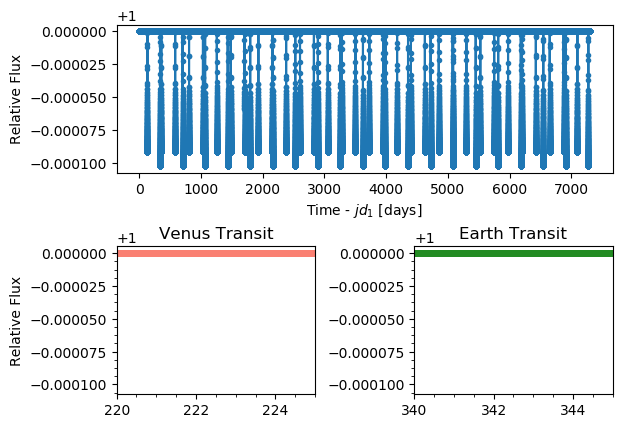

(340, 345)

In [13]:
using PyPlot
fig,ax=subplots()#,dpi=150)
subplots_adjust(hspace=0.5,wspace=0.5)
subplot(211)
plot(lc.tobs,lc.flux .+1,marker=".")
xlabel(L"Time - $jd_1$ [days]")
ylabel("Relative Flux")
subplot(223,title="Venus Transit")
plot(lc.tobs,lc.flux .+1,marker=".",color="salmon")
# xlabel("Time [days]")
ylabel("Relative Flux")
minorticks_on()
xlim(100,2)
subplot(224,title="Earth Transit")
plot(lc.tobs,lc.flux .+1,marker=".",color="forestgreen")
minorticks_on()
# xlim(340,345)
# plt.show()

For V+E, dynamic transit times occur before JPL mathematical transit times. Effect of moon? Likely increase accuracy of nbody 
Differences between "observed" transit times from JPL and dynamic transit times from NBoddy gradient range 
Is there a difference in reference angle? (can't remember how to compute)

In [50]:
RV_semiamplitude(4332.82,CGS.MJUPITER/1e3,0.048,1.305,CGS.MSUN/1e3)

15.181784137362147

221.80266718922505
221.7838978483332
221.78392439686857


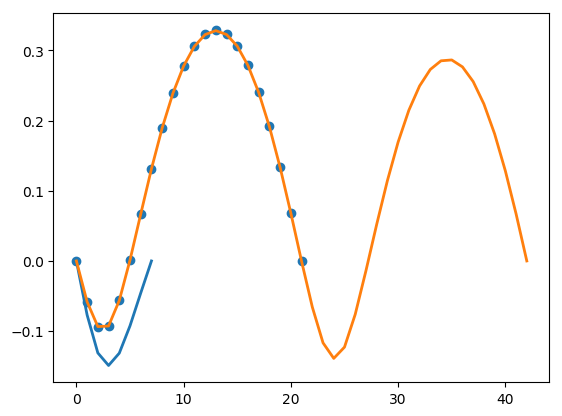

In [14]:
a = Elements(m = 0.82)
b = Elements(
        m = 3.18e-4,
        P = 221.717,
        ecosω = 0.0069,
        I = pi/2,
)
c = Elements(
        m = 3e-6,
        P = 228.774,
        t0 = -228.774/6, # < We want mean anomaly to be +60 deg, so its
        ecosω  = 0.0054, #   transit should have about occurred 1/6 of an orbit 
        I = pi/2         #   prior to the initial time.
)

# Set up the integrator.
t0 = 7257.93115525  # Initialize IC, must be before first transit
h = 0.5       # Time step
tmax = 9837.282 # Time to integrate to.
# Generate the initial conditions
# ic = ElementsIC(t0,8,"T1_elements.txt")
ic = ElementsIC(0.0,3,a,b,c)
s = State(ic)
intr = Integrator(h, 0.0, tmax)
tt = TransitTiming(tmax,ic); #allocate arrays to hold transit times and derivatives
# Now, run the integrator!
intr(s,tt) # pass a TransitTiming structure to the integrator

# plot the transit timing variations
t1 = tt.tt[2,1:tt.count[2]]
nplot = [8,22,43]
for iplot=1:3
  pavg = mean(t1[2:nplot[iplot]] - t1[1:nplot[iplot]-1])
  it = collect(0:1:nplot[iplot]-1)
  ttv1 = t1[1:nplot[iplot]] .- it .* pavg .- t1[1]
  if iplot == 2
    scatter(it,ttv1)
  else
    plot(it,ttv1)
  end
  println(pavg)
end

Results above match NbodyGradient TTV example. https://github.com/ericagol/NbodyGradient.jl/blob/master/examples/ttv_example.ipynb

In [11]:
using DataFrames,CSV

In [51]:
"""
---     KOI-S   Kepler Object of Interest number of star
                 (KOI -NNNN in Simbad)
---     KIC     [1718189/12314973] Kepler Input Catalog number
                 of star (KIC NNNNNNNN in Simbad)
---     KOI-P   Kepler Object of Interest number of planet
                 (KOI -NNNN.NN in Simbad)
---     Kepler  Kepler name of planet, if named (Kepler -NNNNAa
                 in Simbad)
Msun    M*      [0.624/1.4332] Stellar mass
Msun    R*      [0.614/3.36] Stellar radius
---     CDPP    [9.986/384.892] The 6-hour Combined Differential
                   Photometric Precision (CDPP_6hr_)
---     b       [0.0004/0.8999] Impact parameter
d       Per     Orbital period
Rgeo    Rp      Planet radius
Rgeo  e_Rp      Uncertainty in Rp
K       Teq     Equilibrium temperature
Rgeo    RpAvg   [0/11.3289969329] Average planet radius (1)
---     Pj+1/Pj [0/81.7781148492] Orbital period ratio
                  P_j+1_/P_j_ (1)
---     Delta   [0/82.8903285681] Mutual Hill radius {Delta}_RH_
                                 (1)
--------------------------------------------------------------------------------
Note (1): Of this planet and interior planet.
"""
CKS_names=["KOI-S","KIC","KOI-P","Kepler","Mstar","Rstar","CDPP","b","Per","Rp","e_Rp","Teq","RpAvg","Pj+1/Pj","Delta"]
CKS=readdlm("data/CKS.dat")
CKS_raw=DataFrame(CKS,CKS_names)
CKS_data=identity.(CKS_raw)

Row,KOI-S,KIC,KOI-P,Kepler,Mstar,Rstar,CDPP,b,Per,Rp,e_Rp,Teq,RpAvg,Pj+1/Pj,Delta
,SubStrin…,Int64,SubStrin…,Any,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,K00041,6521045,K00041.02,Kepler-100 b,1.107,1.55,23.331,0.5134,6.88706,1.35499,0.235962,1186.84,0.0,0.0,0.0
2,K00041,6521045,K00041.03,Kepler-100 d,1.107,1.55,23.331,0.5942,35.3331,1.54031,0.318251,687.853,1.95734,2.75698,31.2311
3,K00041,6521045,K00041.01,Kepler-100 c,1.107,1.55,23.331,0.5891,12.8159,2.37437,0.344682,965.148,1.86468,1.86086,20.1539
4,K00046,10905239,K00046.02,Kepler-101 c,1.156,1.58,54.612,0.4143,6.0298,1.18082,0.165451,1203.27,3.43956,1.72888,12.918
5,K00046,10905239,K00046.01,Kepler-101 b,1.156,1.58,54.612,0.0356,3.48769,5.6983,0.73868,1443.88,0.0,0.0,0.0
6,K00070,6850504,K00070.05,Kepler-20 f,0.934,0.949,39.416,0.3268,19.5776,1.01612,0.0870208,634.732,2.05855,1.80371,18.3685
7,K00070,6850504,K00070.03,Kepler-20 d,0.934,0.949,39.416,0.1206,77.6116,2.68703,0.219742,401.065,1.85157,3.9643,42.2023
8,K00070,6850504,K00070.01,Kepler-20 c,0.934,0.949,39.416,0.4384,10.8541,3.10099,0.277416,772.508,1.97241,1.77979,18.3415
9,K00070,6850504,K00070.02,Kepler-20 b,0.934,0.949,39.416,0.8424,3.69612,2.15717,0.256781,1106.44,0.0,0.0,0.0


In [55]:
"""
  ---     KOI       Kelper Object of Interest identifier (1)
  d       Period    Orbital period
  d       T0        Barycentric Julian Date of minimum;
                                   BJD-2454900.0
  h       Tdur      Eclipse duration
  Rgeo    Rp        Planetary radius; Earth radii
  ---     S/N       Signal-to-Noise
  Msun    M*        Stellar mass
  Rsun    R*        Stellar radius
  ---     P/P-      ? Ratio of orbital periods (2)
  ---     Delta-    ? Orbital separation (3)
--------------------------------------------------------------------------------
Note (1): Systems (integer part of KOI numbers) ordered by increasing
          multiplicity, then numerically. Within each system, planets are
          ordered by increasing orbital period. The decimal part of KOI
          numbers (".01", ".02", etc.) refers to the order of discovery.
Note (2): Between this planet and the adjacent planet with a smaller period.
Note (3): Between this planet and the adjacent planet with a smaller period.
          In units of Hill radii, see Equ. 3.
"""
MTS_names=["KOI","Per","T0","Tdur","Rp","SNR","Mstar","Rstar","Pj+1/Pj","Delta"]
MTS=readdlm("data/MTS.dat")
MTS_raw=DataFrame(MTS,MTS_names)
MTS_data=identity.(MTS_raw)

Row,KOI,Per,T0,Tdur,Rp,SNR,Mstar,Rstar,Pj+1/Pj,Delta
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Any,Any
1,5.01,4.78033,65.9732,2.0117,5.65,338.1,1.14,1.42,,
2,5.02,7.05186,66.3669,3.6882,0.66,8.5,1.14,1.42,1.47518,8.2
3,46.01,3.48769,103.931,4.0237,4.32,284.8,1.11,1.1,,
4,46.02,6.02908,65.5147,3.7909,0.96,9.7,1.11,1.1,1.72867,13.5
5,72.01,0.83749,64.5744,1.8123,1.38,139.2,0.9,1.0,,
6,72.02,45.294,71.6781,6.8594,2.19,122.4,0.9,1.0,54.0831,87.9
7,89.01,84.689,83.5651,10.0555,4.87,55.6,1.96,2.6,,
8,89.02,207.603,222.869,6.9868,6.47,45.2,1.96,2.6,2.45136,17.4
9,108.01,15.9653,75.1763,4.6518,2.94,84.7,1.14,1.21,,


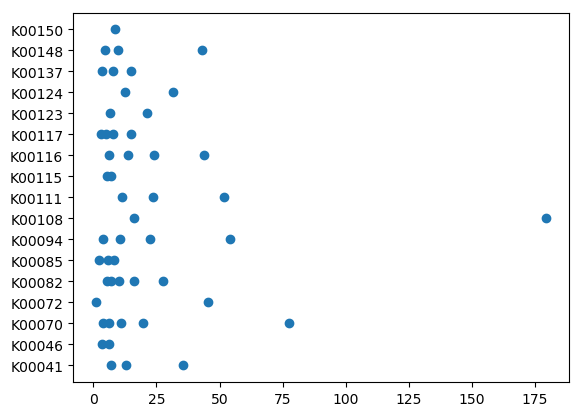

PyObject <matplotlib.collections.PathCollection object at 0x7f90c4463470>

In [62]:
using PyPlot 
scatter(CKS_data.Per[1:50],CKS_data[!, "KOI-S"][1:50])

In [63]:
for i = 1:len(MTS_data.KOI)
    MTS_data.KOI

939-element Vector{Float64}:
    5.01
    5.02
   46.01
   46.02
   72.01
   72.02
   89.01
   89.02
  108.01
  108.02
  112.02
  112.01
  119.01
    ⋮
 1364.01
 1589.04
 1589.01
 1589.02
 1589.03
 1589.05
  157.06
  157.01
  157.02
  157.03
  157.04
  157.05

In [38]:
cks.Delta

LoadError: type Tuple has no field Delta

In [5]:
lk=pyimport("lightkurve")
search_result = lk.search_lightcurve("Kepler-36", author="Kepler")
lc_collection=search_result.download_all()

PyObject LightCurveCollection of 53 objects:
    0: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=0 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 11401755" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1